<a href="https://colab.research.google.com/github/Shihab7u/Chicken-Disease-Detection-and-Classification/blob/main/Chicken_Disease_Detection_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init

In [ ]:
from tf_helper_functions import (
    delete_dir,
    split_dataset_train_test,
    walk_through_dir,
    create_subset_dataset,
    view_random_image,
    augment_random_image,
    plot_loss_curves_mplt,
    plot_loss_curves_plotly,
    create_tensorboard_callback,
    create_feature_extractor_model,
    compare_histories_plotly,
    compare_histories_mplt,
    get_callbacks
)

## Dataset

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1rg9RdjlUoQ-QrhpK8Fu5mIU5p_0RispT/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1rg9RdjlUoQ-QrhpK8Fu5mIU5p_0RispT
To: /content/Chicken_dataset.zip
100% 8.47G/8.47G [01:39<00:00, 85.0MB/s]


In [ ]:
!unzip "/content/Chicken_dataset.zip" > /dev/null

In [ ]:
split_dataset_train_test(
    src_directory="/content/Chicken_big_dataset",
    dest_directory="data",
    split_ratio =.3,
    random_state = 40
)

Copying train files:   0%|          | 0/4768 [00:00<?, ?it/s]

Copying test files:   0%|          | 0/2044 [00:00<?, ?it/s]

Number of train files: 4768
Number of test files: 2044


In [ ]:
walk_through_dir("data")

There are 2 directories and 0 images in 'data'.
There are 4 directories and 0 images in 'data/test'.
There are 0 directories and 113 images in 'data/test/ncd'.
There are 0 directories and 631 images in 'data/test/cocci'.
There are 0 directories and 683 images in 'data/test/salmo'.
There are 0 directories and 617 images in 'data/test/healthy'.
There are 4 directories and 0 images in 'data/train'.
There are 0 directories and 263 images in 'data/train/ncd'.
There are 0 directories and 1472 images in 'data/train/cocci'.
There are 0 directories and 1593 images in 'data/train/salmo'.
There are 0 directories and 1440 images in 'data/train/healthy'.


Image Path: data/train/salmo/salmo.910.jpg
Width: 3200
Height: 1440
Channels: 3


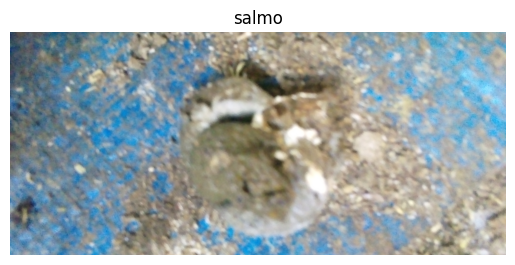

In [ ]:
view_random_image(
    root_path="data",
    file_extension="jpg"
)

## Model

# **CNN Layer**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.regularizers  import l2

# Clear GPU memory
tf.keras.backend.clear_session()


from keras.utils import plot_model
def get_feature_cnn(inputs):
    # Add the preprocessing/augmentation layers.
    x = layers.RandomFlip(mode='horizontal_and_vertical')(inputs)
    x = layers.RandomRotation(0.1)(x)
    x = layers.RandomZoom(0.2)(x)

    # Add the model layers.
    x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)# Adding Batch Normalization
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)# Adding Batch Normalization
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)# Adding Batch Normalization
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(filters=512, kernel_size=3, activation='relu',kernel_regularizer=l2(0.01))(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)# Adding Batch Normalization
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(filters=1024, kernel_size=3, activation='relu',kernel_regularizer=l2(0.01))(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)# Adding Batch Normalization
    x = layers.Dropout(0.3)(x)


    x = layers.Flatten()(x)



    x = layers.Dense(1024, activation='relu',kernel_regularizer=l2(0.01))(x)
    x = layers.Dense(512, activation='relu',kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    return x

# **Pre-Trained Layer**

In [ ]:
def get_feature_pretrained(inputs):
    # Add the preprocessing/augmentation layers.
    x = layers.RandomFlip(mode='horizontal_and_vertical')(inputs)
    x = layers.RandomRotation(0.1)(x)
    x = layers.RandomZoom(0.2)(x)

    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet',input_shape=(224, 224, 3))

    # Fine-tune only the last few layers of the pre-trained model
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    x = base_model(x, training=False)
    x = layers.BatchNormalization()(x)  # Adding Batch Normalization
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(1024, activation='relu',kernel_regularizer=l2(0.01))(x)
    x = layers.Dense(512, activation='relu',kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    return x


# **Concanate-Hybrid**

In [ ]:

# Create input layer
inputs = layers.Input(shape=(224, 224, 3))

# Get features from CNN model
cnn_features = get_feature_cnn(inputs)

# Get features from pretrained model
pretrained_features = get_feature_pretrained(inputs)

# Concatenate the features
combined_features = layers.concatenate([cnn_features, pretrained_features])

# Add a dense layer for classification
# x = layers.Dense(256, activation='relu',kernel_regularizer=l2(0.01))(combined_features)
x = layers.Dense(128, activation='relu',kernel_regularizer=l2(0.01))(combined_features)
outputs = layers.Dense(4, activation='softmax')(x)

# Create the combined model
combined_model = models.Model(inputs=inputs, outputs=outputs)

# Print the model summary
# combined_model.summary()


# plot_model(combined_model, show_shapes=True)

80134624/80134624 [==============================] - 4s 0us/step


# **Model Summary**

In [ ]:
# Load the model
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip (RandomFlip)       (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 random_rotation (RandomRotatio  (None, 224, 224, 3)  0          ['random_flip[0][0]']            
 n)                                                                                               
                                                                                              

# **Model Architecture**

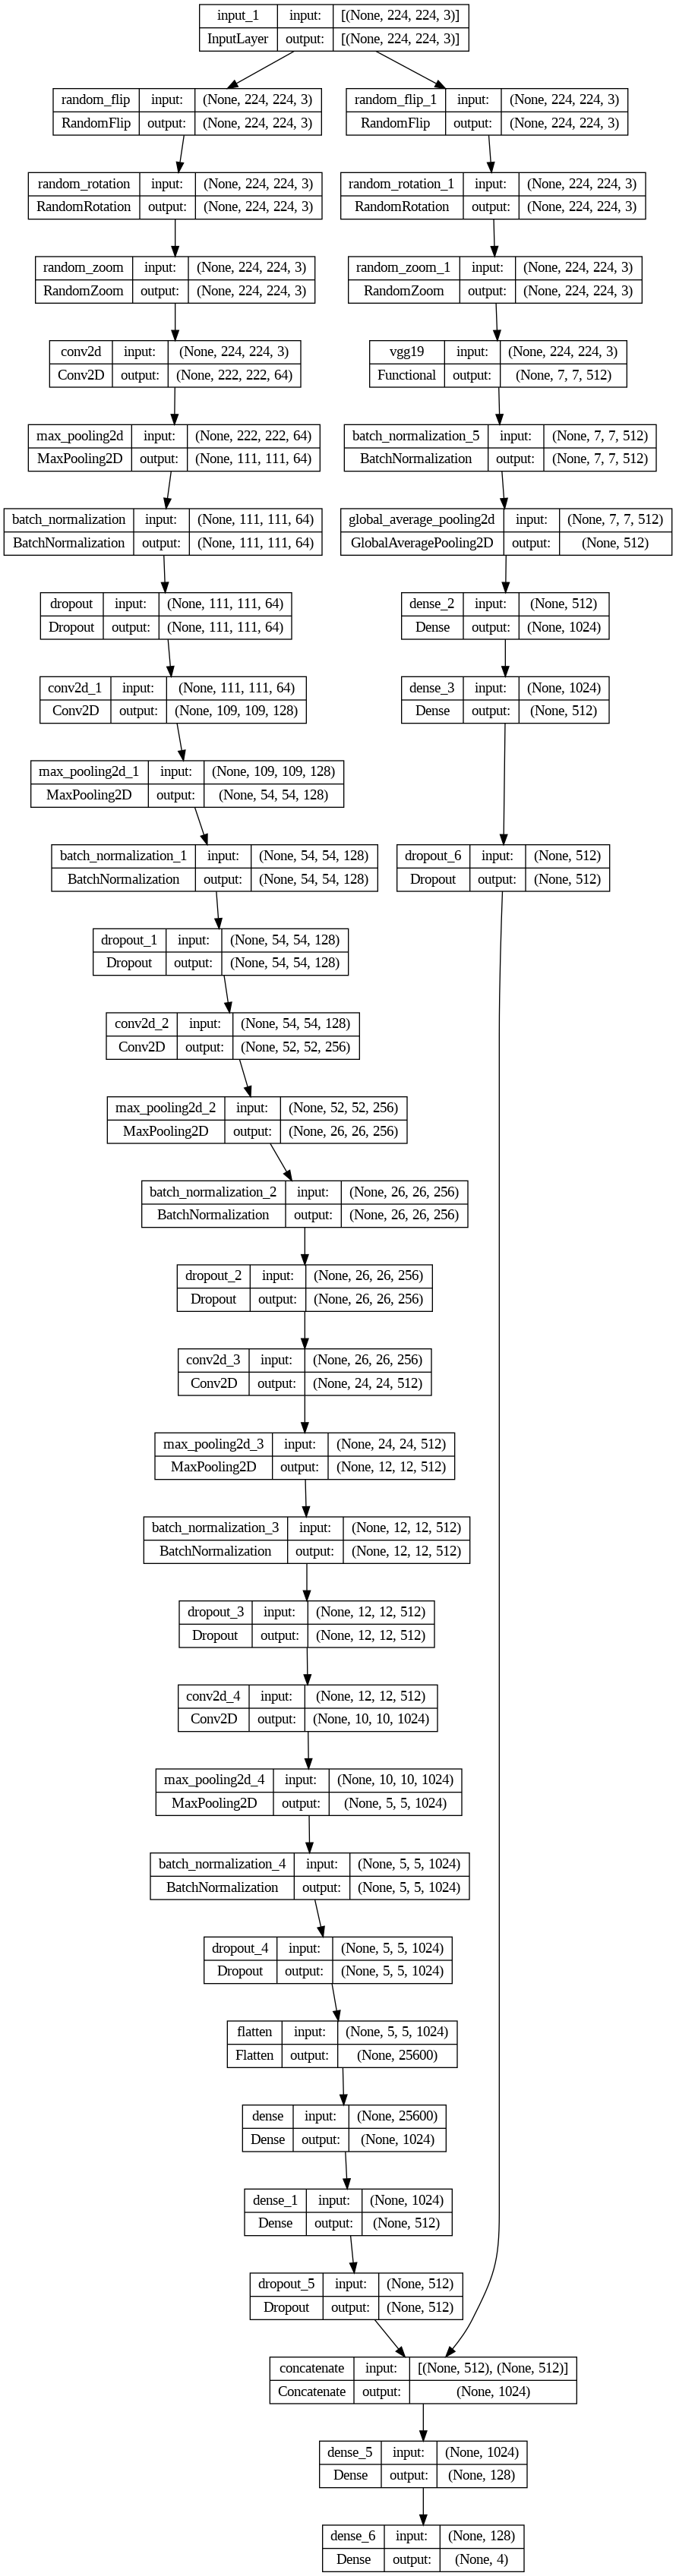

In [ ]:
# plot model architecture
from keras.utils import plot_model
plot_model(combined_model, show_shapes=True, to_file='Model Architecture.png')

# **Model Evaluation**
# **Train Model**

In [ ]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 64
tf.keras.backend.clear_session()

train_dir_full = "data/train"
test_dir = "data/test"
train_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_full,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE, # default
                                                                           image_size=IMAGE_SHAPE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SHAPE,
                                                                shuffle=False)
combined_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

# Get the callbacks
callbacks = get_callbacks()
h2=combined_model.fit(train_full,
                    epochs=60,
                    initial_epoch = 0,
                    steps_per_epoch=len(train_full),
                    validation_data=test_data,
                    validation_steps=int(len(test_data)),
                    callbacks=callbacks )

Found 4768 files belonging to 4 classes.
Found 2044 files belonging to 4 classes.
Epoch 1/60
75/75 [==============================] - ETA: 0s - loss: 48.6892 - accuracy: 0.8364
Epoch 1: val_loss improved from inf to 47.69329, saving model to model_weights.h5
75/75 [==============================] - 279s 3s/step - loss: 48.6892 - accuracy: 0.8364 - val_loss: 47.6933 - val_accuracy: 0.3459 - lr: 1.0000e-04
Epoch 2/60
75/75 [==============================] - ETA: 0s - loss: 38.8432 - accuracy: 0.9193
Epoch 2: val_loss improved from 47.69329 to 34.99438, saving model to model_weights.h5
75/75 [==============================] - 230s 3s/step - loss: 38.8432 - accuracy: 0.9193 - val_loss: 34.9944 - val_accuracy: 0.7123 - lr: 1.0000e-04
Epoch 3/60
75/75 [==============================] - ETA: 0s - loss: 30.3869 - accuracy: 0.9415
Epoch 3: val_loss improved from 34.99438 to 26.74375, saving model to model_weights.h5
75/75 [==============================] - 229s 3s/step - loss: 30.3869 - accurac

In [ ]:
# from tensorflow.keras.models import save_model, load_model

# # Save the model
# combined_model.save("combined_model.h5")

# # Load the model
# loaded_model = load_model("combined_model.h5")
# loaded_model.summary()

In [ ]:
# plot_model(loaded_model, show_shapes=True)

# **Accuracy & Loss Curve**

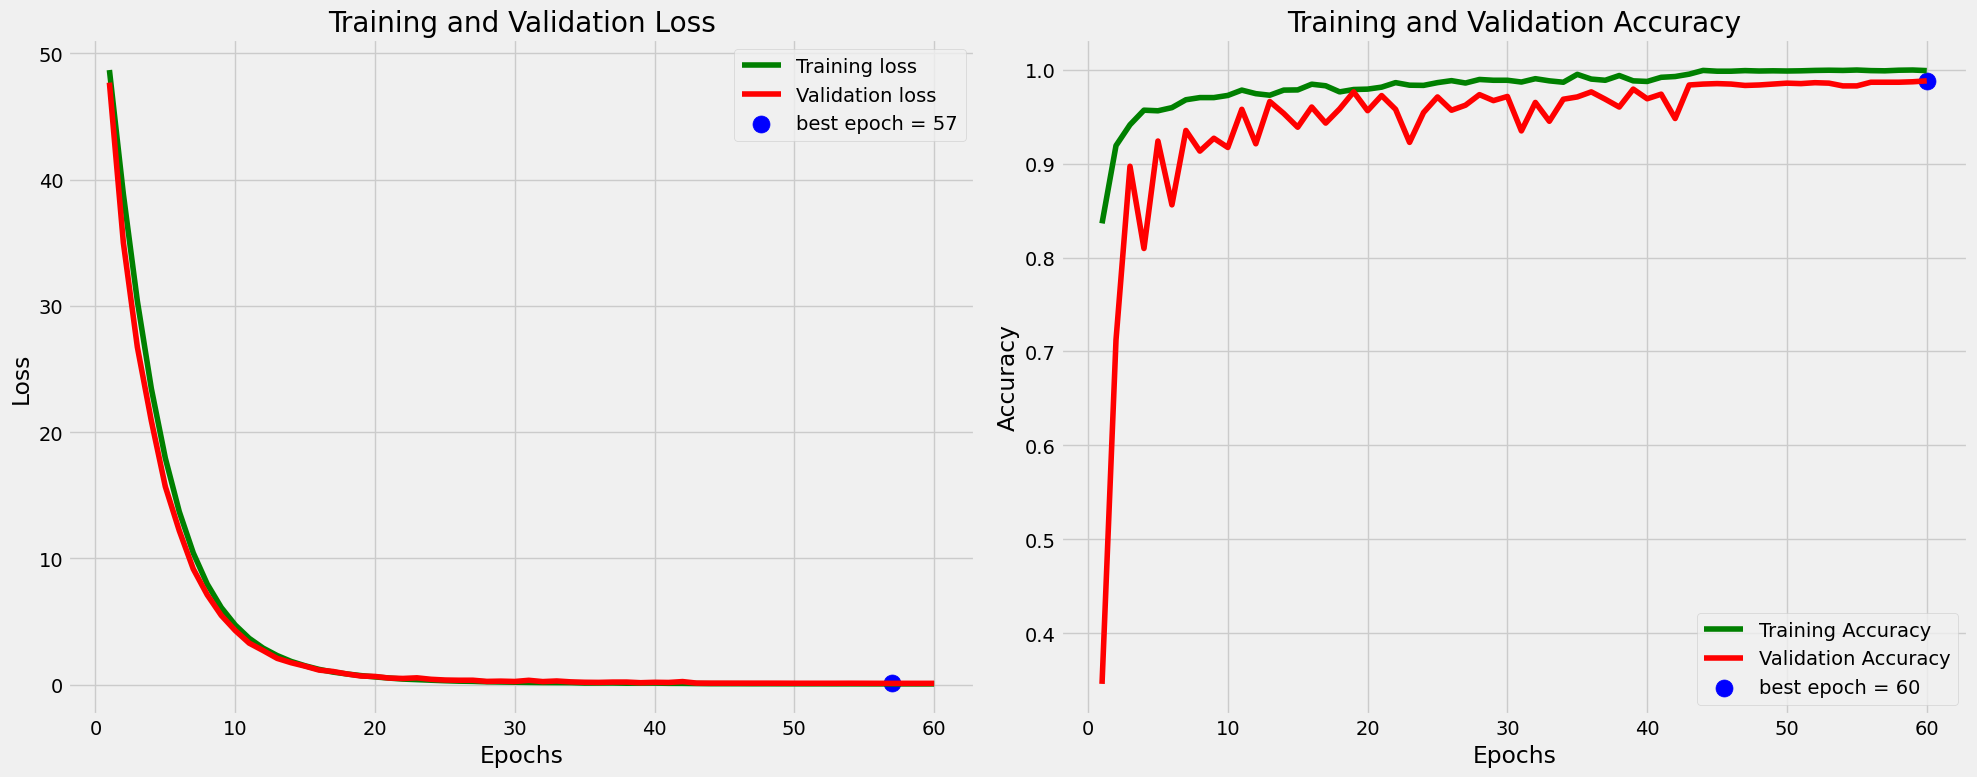

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def tr_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)  # This is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch = ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch = ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, 'g', label='Training loss')
    axes[0].plot(Epochs, vloss, 'r', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'g', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'r', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout()
    plt.show()

tr_plot(h2, 0)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


# **Test-Data Result**

In [ ]:
# Get the predicted labels for the test data
res = combined_model.evaluate(test_data)
res

64/64 [==============================] - 63s 986ms/step - loss: 0.1105 - accuracy: 0.9883


[0.11051488667726517, 0.9882583022117615]

In [ ]:
test_dir = "data/test"
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SHAPE,
                                                                shuffle=False)
class_names= test_data.class_names
y_prob = combined_model.predict(test_data)
y_pred = y_prob.argmax(axis=1)
y_pred

Found 2044 files belonging to 4 classes.
64/64 [==============================] - 56s 863ms/step


array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
y_true = []
for images, labels in test_data:
    y_true.extend(np.argmax(labels, axis=1))
y_true = np.array(y_true)
y_true

array([0, 0, 0, ..., 3, 3, 3])

# **Confusion Matrix**

In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))


Confusion Matrix:
[[630   0   0   1]
 [  3 608   1   5]
 [  0   9 104   0]
 [  2   3   0 678]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       631
           1       0.98      0.99      0.98       617
           2       0.99      0.92      0.95       113
           3       0.99      0.99      0.99       683

    accuracy                           0.99      2044
   macro avg       0.99      0.97      0.98      2044
weighted avg       0.99      0.99      0.99      2044



# **Heatmap**

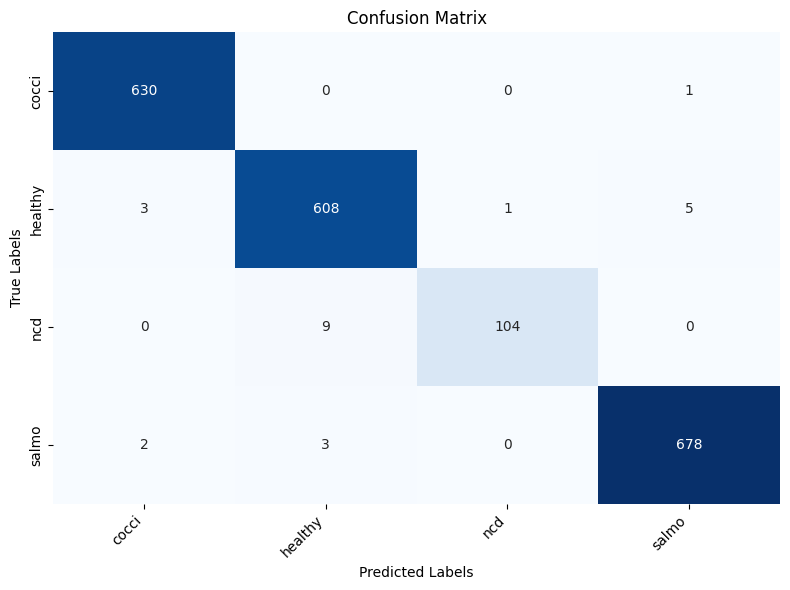

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a figure and axes
plt.figure(figsize=(8, 6))
ax = plt.subplot()

# Plot confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

# Rotate tick labels for better visibility
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Show the plot
plt.tight_layout()
plt.show()


# **ROC Curve**

64/64 [==============================] - 71s 1s/step


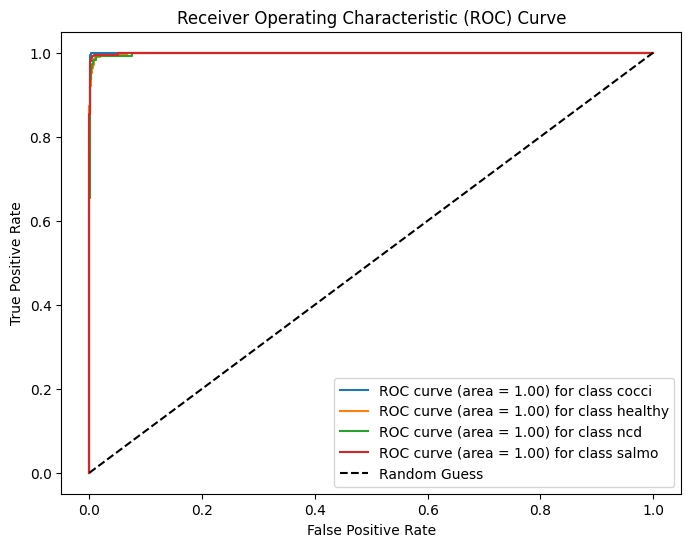

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the probabilities for each class
y_probs = combined_model.predict(test_data)

# Convert the true labels to binary format
y_true_binary = np.zeros((len(y_true), len(class_names)))
y_true_binary[np.arange(len(y_true)), y_true] = 1

# Compute the false positive rate (FPR), true positive rate (TPR), and area under the curve (AUC) for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], class_names[i]))

# Plot the random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Set labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show the plot
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
combined_model.save('/content/drive/MyDrive/Colab Notebooks/checkpoint/model_v1.h5')
